In [6]:
import os
import pyredner
import numpy as np
import torch
import math
import sys

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from tqdm.notebook import tqdm
from IPython.display import clear_output
from typing import Union

# Use GPU if available
pyredner.set_use_gpu(torch.cuda.is_available())
pyredner.render_pytorch.print_timing = False

sys.path.append('../')
from utils.plot_target_image import image_grid

In [7]:
def gamma_encode(image):
    return image ** (1.0/2.2)

In [8]:
#to generate camera poses for synthetic scenes

def getPhi(x, y, z):
    return math.atan2(math.sqrt(x*x + z * z), y)

def getTheta(x, y, z):
    return math.atan2(x, -z)


def getRadius(x, y, z):
    return math.sqrt(x*x + y * y + z * z)

def getX(radius, theta, phi):
    return radius * math.sin(phi*0.01745) * math.cos(theta*0.01745);


def getY(radius, theta, phi):
    return radius * math.sin(phi*0.01745) * math.sin(theta*0.01745);


def getZ(radius, theta, phi):
    return radius * math.cos(phi*0.01745);

def generateCameraPoses():
    radius = 3
    camera_poses = []
    for phi in range(20, 121, 30): #controls the different altitude
        for theta in range(0, 360, 30): #number of images per orbit
            camera_poses.append([getX(radius, theta, phi), getZ(radius, theta, phi), getY(radius, theta, phi)])
    return camera_poses            

cam_poses = generateCameraPoses()

In [9]:
obj_file = 'data/spot/spot.obj'
target_object = pyredner.load_obj(obj_file, return_objects = True)
camera = pyredner.automatic_camera_placement(target_object, resolution=(256,256))

In [10]:
envmap = pyredner.EnvironmentMap(0.7 * torch.ones(1, 1, 3).cuda())

In [11]:
#uncomment below to try with real world outdoor envmap

# envmap = pyredner.imread('envmap/outdoor.exr')
# if pyredner.get_use_gpu():
#     envmap = envmap.cuda(device = pyredner.get_device())
# envmap = pyredner.EnvironmentMap(envmap, directly_visible= True)

In [12]:
cams = []
for i in range(len(cam_poses)):
    cam = pyredner.Camera(position = torch.tensor(cam_poses[i]) ,
                         look_at = camera.look_at,
                         up = camera.up,
                         fov = camera.fov,
                         resolution = camera.resolution)
    cams.append(cam)

In [13]:
#generating the target scenes using redner

target_scenes = []
for j in range(len(cam_poses)):
    scene = pyredner.Scene(camera = cams[j], objects = target_object, envmap = envmap)
    target_scenes.append(scene)

In [14]:
#rendering and storing all the scene as a batch

target_img = []
for k in tqdm(range(len(cam_poses))):
    target_args = pyredner.RenderFunction.serialize_scene(scene=target_scenes[k],
                                                          num_samples = 128,
                                                          max_bounces = 2)

    render = pyredner.RenderFunction.apply

    img = render(0, *target_args)
    img = img.clamp(0,1)
    target_img.append(img)

  0%|          | 0/48 [00:00<?, ?it/s]

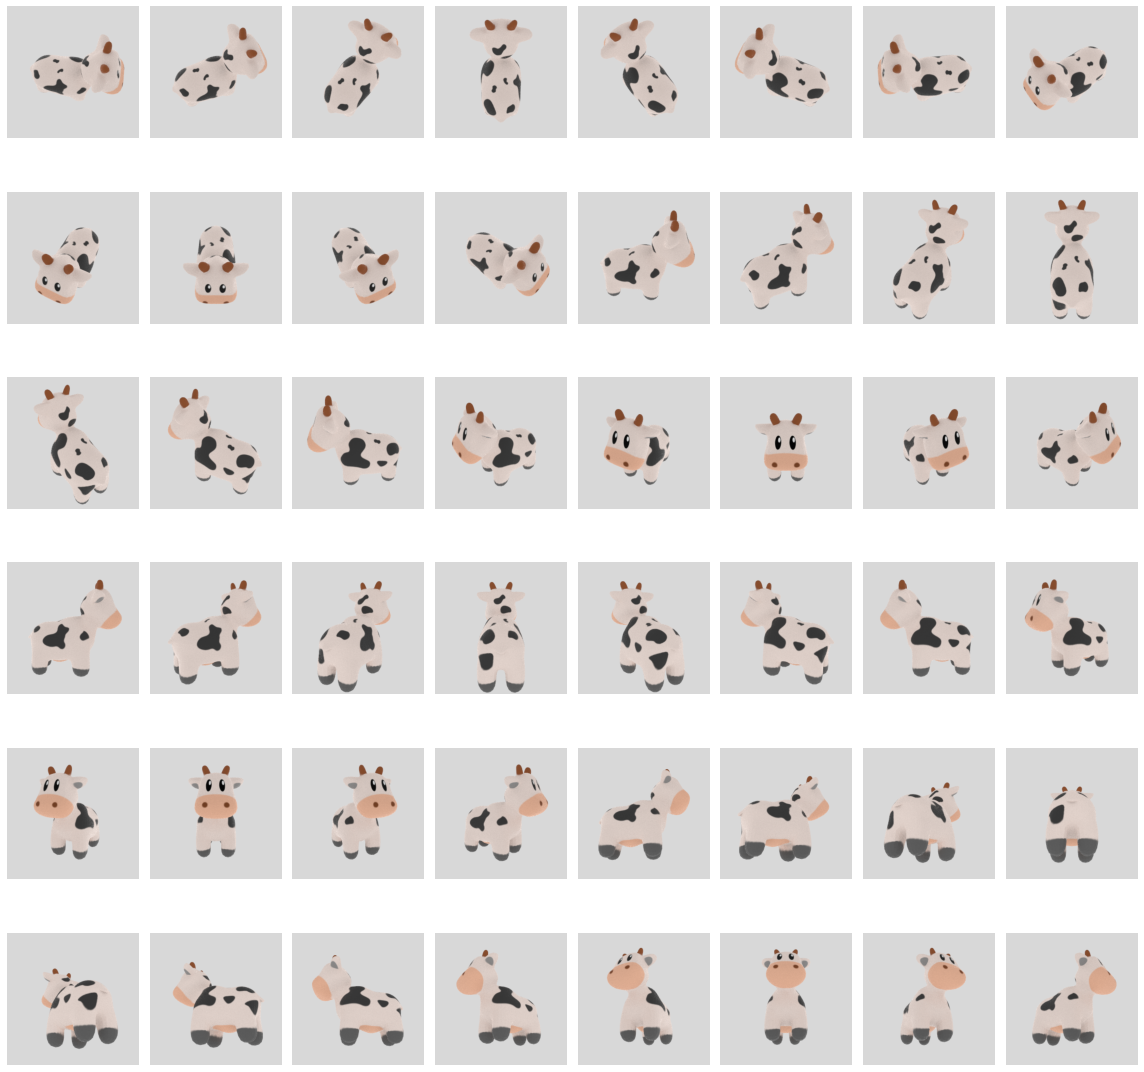

In [15]:
image_grid(target_img, rows = 6, cols = 8)

In [16]:
#loading the geometry to compute the uv_index, vertex and normals
material_map, mesh_list, light_map = pyredner.load_obj(obj_file)
for _,mesh in mesh_list:
    mesh_normals = pyredner.compute_vertex_normal(mesh.vertices, mesh.indices)
    computed_uvs = pyredner.compute_uvs(mesh.vertices, mesh.indices)    
uv_vertex, uv_index = computed_uvs

In [17]:
#initializing diffuse, specular and roughness, and assigning them as material

diffuse_tex = torch.tensor(\
    np.ones((256, 256, 3), dtype=np.float32) * 0.0,
    requires_grad = True,
    device = pyredner.get_device())


specular_tex = torch.tensor(\
        np.ones((256,256,3),dtype=np.float32)*0.0,
        requires_grad = True,
        device = pyredner.get_device())


roughness_tex = torch.tensor(\
    np.ones((256, 256, 1), dtype=np.float32) * 0.5,
    requires_grad = True,
    device = pyredner.get_device())

mat = pyredner.Material(diffuse_reflectance=pyredner.Texture(diffuse_tex), 
                       specular_reflectance=pyredner.Texture(specular_tex),
                       roughness=pyredner.Texture(roughness_tex))


In [18]:
objects = pyredner.Object(vertices = mesh.vertices,
                         indices = mesh.indices,
                         uvs = uv_vertex,
                         uv_indices = uv_index,
                         normals = mesh_normals,
                         material = mat)

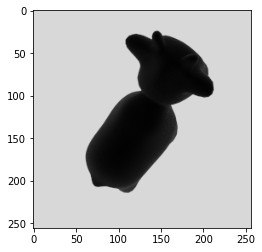

In [19]:
#visualizing one sene with initial materials

scene = pyredner.Scene(cams[2], objects = [objects], envmap=envmap)
img  = pyredner.render_pathtracing(scene=scene, num_samples=128)
imshow(gamma_encode(img).detach().cpu());

In [20]:
optimizer = torch.optim.Adam([diffuse_tex], lr = 1e-2 , weight_decay = 1e-4 )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=65, gamma=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(199) Loss: 852.880554


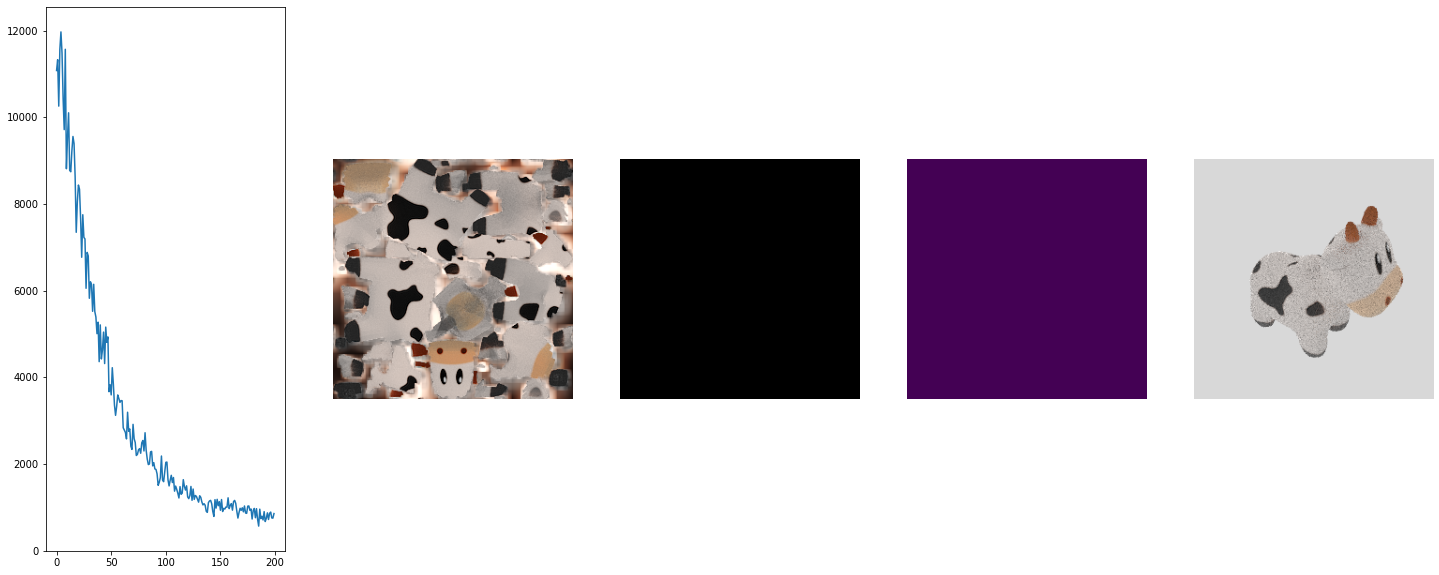

In [21]:
n = 0
num_views_per_iteration = 5 #20
losses = []

for t in tqdm(range(200)):
    print('Iteration: ', t)
    optimizer.zero_grad()
    
    mat.diffuse_reflectance = pyredner.Texture(diffuse_tex)
    mat.specular_reflectance = pyredner.Texture(specular_tex)
    mat.roughness = pyredner.Texture(roughness_tex)   
    
    total_loss = 0
    
    for j in tqdm(np.random.permutation(len(cams)).tolist()[:num_views_per_iteration]):
        
        scene = pyredner.Scene(cams[j], objects = [objects], envmap = envmap)
        args = pyredner.RenderFunction.serialize_scene(\
                                                  scene = scene,
                                                  num_samples = 4, #16,4
                                                  max_bounces = 2)
        
        render = pyredner.RenderFunction.apply

        img = render(t+1, *args)
        
        pyredner.imwrite(img.cpu(),'results/two_step_optimization/iter_{}.png'.format(t))
       
        loss = torch.pow(img - target_img[j],2).sum()
        total_loss += loss 
   
        n+=1
        
    
    total_loss = total_loss / num_views_per_iteration        
        
    print('Total Loss:', total_loss.item())
    
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    
    diffuse_tex.data = diffuse_tex.data.clamp(0, 1)
    specular_tex.data = specular_tex.data.clamp(0, 1)
    roughness_tex.data = roughness_tex.data.clamp(1e-5, 1)
    
    clear_output(wait=True)
    print("({:d}) Loss: {:f}".format(t, total_loss.item()))
    losses.append(total_loss.item())
    
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 6 ,1)
    plt.plot(losses)
    plt.subplot(1, 6, 2)
    imshow(diffuse_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6, 3)
    imshow(specular_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6, 4)
    imshow(roughness_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6 ,5)
    imshow(gamma_encode(img).detach().cpu())
    plt.axis('off')
    plt.show()

In [22]:
optimizer = torch.optim.Adam([diffuse_tex,specular_tex, roughness_tex], lr = 0.005 , weight_decay = 1e-4 )
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=120, gamma=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(199) Loss: 407.665527


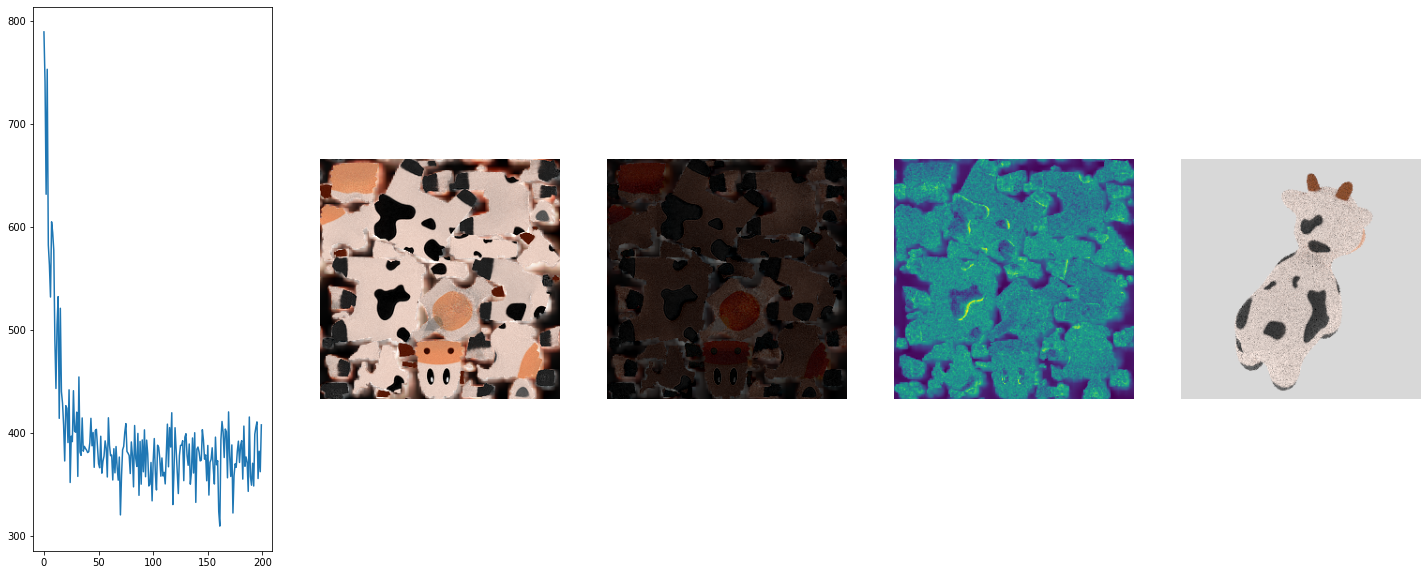

In [23]:
n = 0
num_views_per_iteration = 5 #20
losses = []

for t in tqdm(range(200)):
    print('Iteration: ', t)
    optimizer.zero_grad()
    
    mat.diffuse_reflectance = pyredner.Texture(diffuse_tex)
    mat.specular_reflectance = pyredner.Texture(specular_tex)
    mat.roughness = pyredner.Texture(roughness_tex)   
    
    total_loss = 0
    
    for j in tqdm(np.random.permutation(len(cams)).tolist()[:num_views_per_iteration]):
        
        scene = pyredner.Scene(cams[j], objects = [objects], envmap = envmap)
        args = pyredner.RenderFunction.serialize_scene(\
                                                  scene = scene,
                                                  num_samples = 4, #16,4
                                                  max_bounces = 2)
        
        render = pyredner.RenderFunction.apply

        img = render(t+1, *args)
        
        pyredner.imwrite(img.cpu(),'results/two_step_optimization/iter_{}.png'.format(t))
       
        loss = torch.pow(img - target_img[j],2).sum()
        total_loss += loss 
   
        n+=1
        
    
    total_loss = total_loss / num_views_per_iteration        
        
    print('Total Loss:', total_loss.item())
    
    total_loss.backward()
    optimizer.step()
    scheduler.step()
    
    diffuse_tex.data = diffuse_tex.data.clamp(0, 1)
    specular_tex.data = specular_tex.data.clamp(0, 1)
    roughness_tex.data = roughness_tex.data.clamp(1e-5, 1)
    
    clear_output(wait=True)
    print("({:d}) Loss: {:f}".format(t, total_loss.item()))
    losses.append(total_loss.item())
    
    plt.figure(figsize=(30, 10))
    plt.subplot(1, 6 ,1)
    plt.plot(losses)
    plt.subplot(1, 6, 2)
    imshow(diffuse_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6, 3)
    imshow(specular_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6, 4)
    imshow(roughness_tex.detach().cpu())
    plt.axis('off')
    plt.subplot(1, 6 ,5)
    imshow(gamma_encode(img).detach().cpu())
    plt.axis('off')
    plt.show()

In [24]:
final_scenes = []
for j in range(len(cam_poses)):
    scene = pyredner.Scene(camera = cams[j], objects = [objects], envmap = envmap)
    final_scenes.append(scene)

In [25]:
final_img = []
for k in tqdm(range(len(cam_poses))):
    final_args = pyredner.RenderFunction.serialize_scene(scene=final_scenes[k],
                                                          num_samples = 128,
                                                          max_bounces = 2)

    render = pyredner.RenderFunction.apply

    img = render(0, *final_args)
    img = img.clamp(0,1)
#     pyredner.imwrite(img.cpu(), 'results/two_step_optimization/final_{}.png'.format(k))
    final_img.append(img.detach().cpu())

  0%|          | 0/48 [00:00<?, ?it/s]

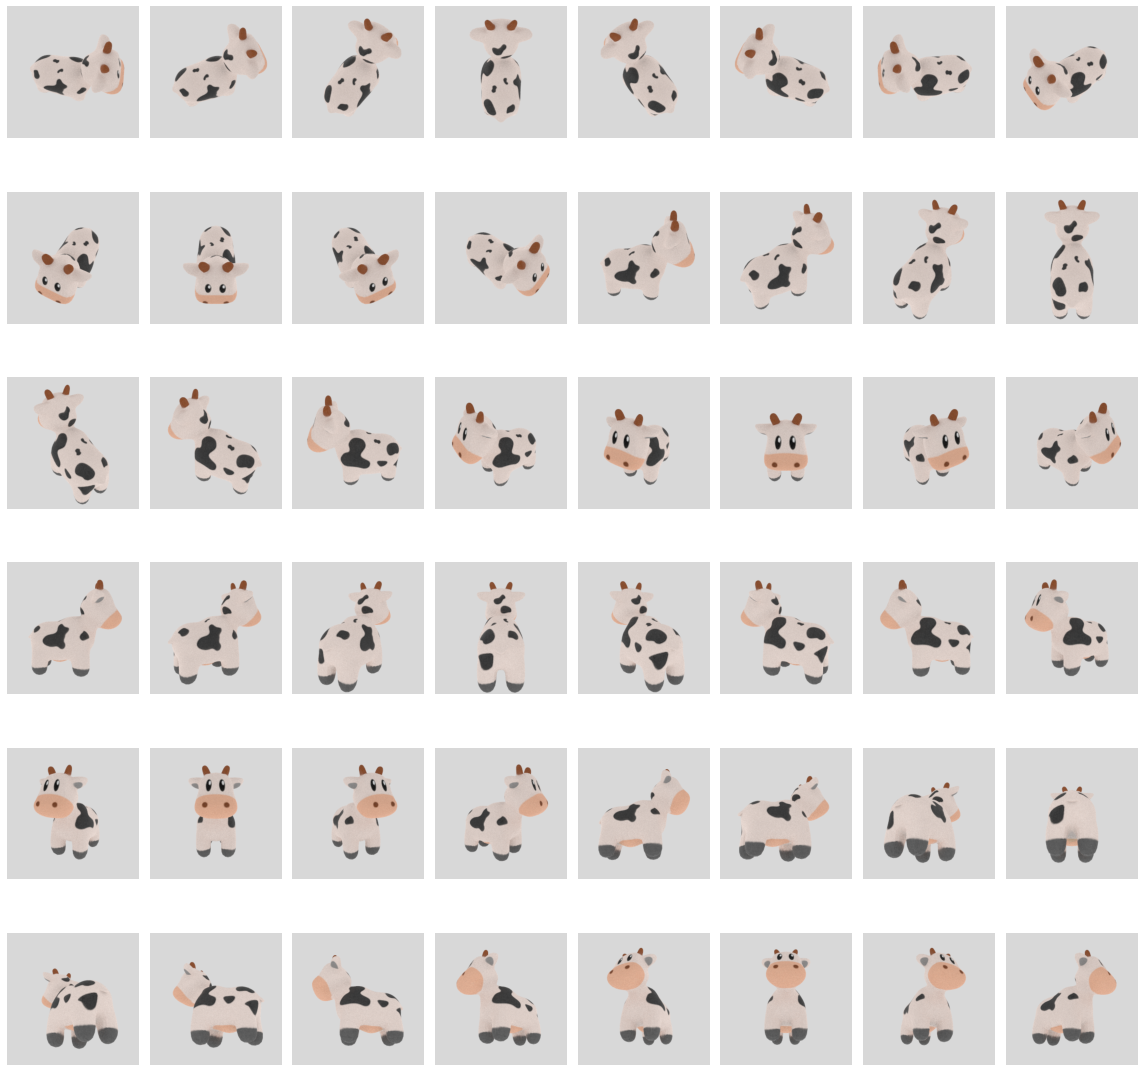

In [26]:
image_grid(final_img, rows = 6, cols = 8)

In [ ]:
#from redner, improving the function to save out the obj file and the optimized material maps

def save_material(m: pyredner.Material,
             filename: str):
    if filename[-4:] != '.mtl':
        filename = filename + '.mtl'
    path = os.path.dirname(filename)

    directory = os.path.dirname(filename)
    if directory != '' and not os.path.exists(directory):
        os.makedirs(directory)
    with open(filename, 'w') as f:
        f.write('newmtl mtl_1\n')

        if m.diffuse_reflectance is not None:
            texels = m.diffuse_reflectance.texels
            if len(texels.size()) == 1:
                f.write('Kd {} {} {}\n'.format(texels[0], texels[1], texels[2]))
            else:
                f.write('map_Kd Kd_texels.png\n')
                pyredner.imwrite(texels.data.cpu(), path + '/Kd_texels.png')
        
        if m.specular_reflectance is not None:
            texels = m.specular_reflectance.texels
            if len(texels.size()) == 1:
                f.write('Ks {} {} {}\n'.format(texels[0], texels[1], texels[2]))
            else:
                f.write('map_Ks Ks_texels.png\n')
                pyredner.imwrite(texels.data.cpu(), path + '/Ks_texels.png')
                
        if m.roughness is not None:
            texels = m.roughness.texels
            if len(texels.size()) == 1:
                f.write('Pr {} {} {}\n'.format(texels[0], texels[1], texels[2]))
            else:
                f.write('map_Ns Ns_texels.png\n')
                pyredner.imwrite(texels.data.cpu(), path + '/Ns_texels.png')
                

                

def save_obj_file(shape: Union[pyredner.Object, pyredner.Shape],
             filename: str,
             flip_tex_coords = True):


    if filename[-4:] != '.obj':
        filename = filename + '.obj'
    path = os.path.dirname(filename)
    name = os.path.basename(filename)[:-4]

    save_material(m=shape.material, filename=filename[:-4])

    directory = os.path.dirname(filename)
    if directory != '' and not os.path.exists(directory):
        os.makedirs(directory)

    with open(filename, 'w') as f:
        f.write('mtllib {}.mtl\n'.format(name))

        vertices = shape.vertices.data.cpu().numpy()
        uvs = shape.uvs.cpu().numpy() if shape.uvs is not None else None
        normals = shape.normals.data.cpu().numpy() if shape.normals is not None else None
        for i in range(vertices.shape[0]):
            f.write('v {} {} {}\n'.format(vertices[i, 0], vertices[i, 1], vertices[i, 2]))
        if uvs is not None:
            for i in range(uvs.shape[0]):
                if flip_tex_coords:
                    f.write('vt {} {}\n'.format(uvs[i, 0], 1 - uvs[i, 1]))
                else:
                    f.write('vt {} {}\n'.format(uvs[i, 0], uvs[i, 1]))
        if normals is not None:
            for i in range(normals.shape[0]):
                f.write('vn {} {} {}\n'.format(normals[i, 0], normals[i, 1], normals[i, 2]))

        f.write('usemtl mtl_1\n')

        indices = shape.indices.data.cpu().numpy() + 1
        uv_indices = shape.uv_indices.data.cpu().numpy() + 1 if shape.uv_indices is not None else None
        normal_indices = shape.normal_indices.data.cpu().numpy() + 1 if shape.normal_indices is not None else None
        for i in range(indices.shape[0]):
            vi = (indices[i, 0], indices[i, 1], indices[i, 2])
            if uv_indices is not None:
                uvi = (uv_indices[i, 0], uv_indices[i, 1], uv_indices[i, 2])
            else:
                if uvs is not None:
                    uvi = vi
                else:
                    uvi = ('', '', '')
            if normal_indices is not None:
                ni = (normal_indices[i, 0], normal_indices[i, 1], normal_indices[i, 2])
            else:
                if normals is not None:
                    ni = vi
                else:
                    ni = ('', '', '')
            if normals is not None:
                f.write('f {}/{}/{} {}/{}/{} {}/{}/{}\n'.format(\
                    vi[0], uvi[0], ni[0],
                    vi[1], uvi[1], ni[1],
                    vi[2], uvi[2], ni[2]))
            elif uvs is not None:
                f.write('f {}/{} {}/{} {}/{}\n'.format(\
                    vi[0], uvi[0],
                    vi[1], uvi[1],
                    vi[2], uvi[2]))
            else:
                f.write('f {} {} {}\n'.format(\
                    vi[0],
                    vi[1],
                    vi[2]))

In [ ]:
save_obj_file(objects,'results/two_step_optimization/optimized/spot')